In [1]:
from makedataset import makeDataset
from model import UNet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import config
import time
import pickle
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.normalization=nn.Softmax(dim=1)

    def forward(self, inputs, targets, smooth=1e-4):
        inputs = self.normalization(inputs)

        targets = targets[:, 1:2, ...]
        inputs = torch.where(inputs[:, 1:2, ...] > 0.5, 1.0, 0.0)

        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return dice

In [3]:
validds=makeDataset(kind='valid',location='data_npy')
validLoader=DataLoader(validds,batch_size=1,shuffle=False, pin_memory=config.PIN_MEMORY)
DiceCoef = DiceScore()

totaldice=0
validstep=0

In [4]:
unet = UNet(64,5,use_xavier=True,use_batchNorm=True,dropout=0.5,retain_size=True,nbCls=2)
devices = 'cpu'
device_num = 0
if torch.cuda.is_available():
    devices = 'gpu'
    device_num = torch.cuda.device_count()
    unet = torch.nn.DataParallel(unet)
unet.to(config.DEVICE)
unet.load_state_dict(torch.load('./final_result/unet.pt'))

<All keys matched successfully>

In [5]:
start_time=time.time()
with torch.no_grad():
    unet.eval()
    for (x,y) in validLoader:
        (x,y) = (x.to(config.DEVICE),y.to(config.DEVICE))
        pred=unet(x)
        dice_score=DiceCoef(pred,y)
        
        validstep+=1      
        totaldice += dice_score
end_time=time.time()
print('Elapsed Time: {:.3f}'.format(end_time-start_time))

Elapsed Time: 601.500


In [6]:
print('Estimated Dice Score for Validation set: {:.04f}%'.format((totaldice/validstep).item()*100))

Estimated Dice Score for Validation set: 95.3493%


# 93.5450% for drop out at evey layer & loss: GDC

# 94.1459% for dropout at every layer and loss Dice Loss

# 94.9923% for drop out at lowest layer and GDC, but Randomcrop 256(4X Faster)

# 95.3493% for drop out at lowest layer and GDC->Final Model

## UNet Model Summary

In [9]:
summary(unet,input_size=(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
              ReLU-2         [-1, 64, 512, 512]               0
       BatchNorm2d-3         [-1, 64, 512, 512]             128
            Conv2d-4         [-1, 64, 512, 512]          36,928
              ReLU-5         [-1, 64, 512, 512]               0
       BatchNorm2d-6         [-1, 64, 512, 512]             128
             Block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
             ReLU-10        [-1, 128, 256, 256]               0
      BatchNorm2d-11        [-1, 128, 256, 256]             256
           Conv2d-12        [-1, 128, 256, 256]         147,584
             ReLU-13        [-1, 128, 256, 256]               0
      BatchNorm2d-14        [-1, 128, 2

In [2]:
with open('./final_result/history.pkl','rb') as f:
    history=pickle.load(f)

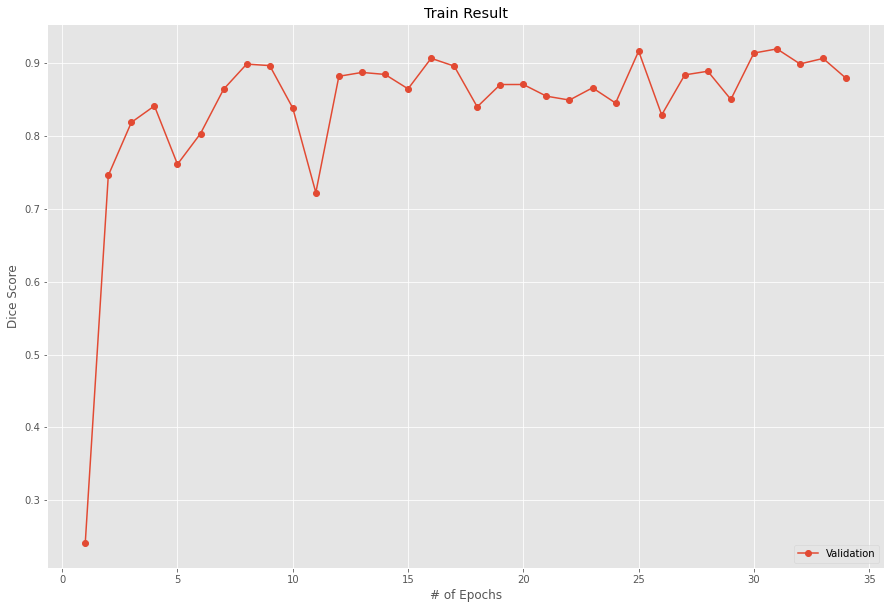

In [3]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
plt.plot(np.arange(1,35),history['dice_valid_score'],'o-',label='Validation')
plt.title('Train Result')
plt.xlabel('# of Epochs')
plt.ylabel('Dice Score')
plt.legend(loc='lower right')
plt.savefig('./final_result/train_result.png')